In [7]:
#ResUNet_ph2_dataset
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Concatenate, Input, UpSampling2D
from tensorflow.keras.models import Model
import numpy as np
import os
import cv2

# ResUNet Model
def resunet(input_shape=(256, 256, 3)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    
    # Encoder (ResNet50)
    s1 = base_model.get_layer('conv1_relu').output  # 256x256
    s2 = base_model.get_layer('conv2_block3_out').output  # 128x128
    s3 = base_model.get_layer('conv3_block4_out').output  # 64x64
    s4 = base_model.get_layer('conv4_block6_out').output  # 32x32
    
    # Bottleneck
    b1 = base_model.get_layer('conv5_block3_out').output  # 16x16
    
    # Decoder
    d1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(b1)
    d1 = Concatenate()([d1, s4])
    d1 = Conv2D(512, (3, 3), padding='same', activation='relu')(d1)
    d1 = BatchNormalization()(d1)
    
    d2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(d1)
    d2 = Concatenate()([d2, s3])
    d2 = Conv2D(256, (3, 3), padding='same', activation='relu')(d2)
    d2 = BatchNormalization()(d2)
    
    d3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d2)
    d3 = Concatenate()([d3, s2])
    d3 = Conv2D(128, (3, 3), padding='same', activation='relu')(d3)
    d3 = BatchNormalization()(d3)
    
    d4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d3)
    d4 = Concatenate()([d4, s1])
    d4 = Conv2D(64, (3, 3), padding='same', activation='relu')(d4)
    d4 = BatchNormalization()(d4)
    
    # Ensure output size matches input size (256x256)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d4)
    outputs = UpSampling2D(size=(2, 2))(outputs)  # Upsample to match original size
    
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Load Data Function
def load_data(image_dir, mask_dir, img_size=(256, 256)):
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    for img_file, mask_file in zip(image_files, mask_files):
        img = cv2.imread(os.path.join(image_dir, img_file))
        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalize
        images.append(img)
        
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = mask / 255.0  # Normalize to [0,1]
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        masks.append(mask)
    
    return np.array(images), np.array(masks)

# Load Dataset
X_train, Y_train = load_data('ph2_dataset/trainx/', 'ph2_dataset/trainy/')

# Compile Model
model = resunet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

# Train Model
history = model.fit(X_train, Y_train, epochs=20, batch_size=16, validation_split=0.2)

# Save Model
model.save('skin_lesion_resunet.h5')


Epoch 1/20


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_192']
Received: inputs=Tensor(shape=(16, 256, 256, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6760 - loss: 0.6546 - mean_io_u_1: 0.3713

C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_192']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6828 - loss: 0.6435 - mean_io_u_1: 0.3705 - val_accuracy: 0.4868 - val_loss: 0.9236 - val_mean_io_u_1: 0.2477
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8734 - loss: 0.3109 - mean_io_u_1: 0.3751 - val_accuracy: 0.4896 - val_loss: 1.2928 - val_mean_io_u_1: 0.2477
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9532 - loss: 0.1606 - mean_io_u_1: 0.3639 - val_accuracy: 0.5034 - val_loss: 1.3793 - val_mean_io_u_1: 0.2477
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9707 - loss: 0.1029 - mean_io_u_1: 0.3608 - val_accuracy: 0.5128 - val_loss: 1.1311 - val_mean_io_u_1: 0.2477
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9763 - loss: 0.0756 - mean_io_u_1: 0.3544 - val_accuracy: 0.4928 - val_loss: 2.9743 - val_mean_io_u_1: 0.2477
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9728 - loss: 0.0953 - mean_io_u_1: 0.3785 - val_accuracy: 0.4928 - val_loss: 

In [21]:
# DermoSegDiff_ph2_dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

# Custom Dataset for Skin Lesion Segmentation
class SkinLesionDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_size)
        img = img / 255.0  # Normalize
        img = np.transpose(img, (2, 0, 1))  # Convert to (C, H, W)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.img_size)
        mask = mask / 255.0  # Normalize to [0,1]
        mask = np.expand_dims(mask, axis=0)  # Add channel dimension
        
        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

# Load Dataset
train_dataset = SkinLesionDataset('ph2_dataset/trainx/', 'ph2_dataset/trainy/')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Define DermoSegDiff Model
class DermoSegDiff(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(DermoSegDiff, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)  # Upsample
        x = self.decoder(x)
        return x

# Initialize Model
model = DermoSegDiff()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()
        
        y_true.extend((masks.cpu().numpy() > 0.5).astype(int).flatten())  # Threshold masks
        y_pred.extend(preds.cpu().numpy().flatten())  # Already thresholded


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred, zero_division=1)
f1 = f1_score(y_true, y_pred, zero_division=1)
iou = jaccard_score(y_true, y_pred, zero_division=1)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'IoU (Jaccard Score): {iou:.4f}')

# Save Model
torch.save(model.state_dict(), 'skin_lesion_dermosegdiff.pth')


Epoch 1/20, Loss: 0.6562
Epoch 2/20, Loss: 0.5990
Epoch 3/20, Loss: 0.5634
Epoch 4/20, Loss: 0.5384
Epoch 5/20, Loss: 0.5228
Epoch 6/20, Loss: 0.4831
Epoch 7/20, Loss: 0.4641
Epoch 8/20, Loss: 0.4339
Epoch 9/20, Loss: 0.4099
Epoch 10/20, Loss: 0.3954
Epoch 11/20, Loss: 0.3863
Epoch 12/20, Loss: 0.3694
Epoch 13/20, Loss: 0.3627
Epoch 14/20, Loss: 0.3611
Epoch 15/20, Loss: 0.3478
Epoch 16/20, Loss: 0.3572
Epoch 17/20, Loss: 0.3459
Epoch 18/20, Loss: 0.3401
Epoch 19/20, Loss: 0.3345
Epoch 20/20, Loss: 0.3424
Accuracy: 0.8538
Precision: 0.7722
Recall: 0.7758
F1 Score: 0.7740
IoU (Jaccard Score): 0.6313


In [1]:
# DermoSegDiff_isic2018/trainx/
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

# Custom Dataset for Skin Lesion Segmentation
class SkinLesionDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_size)
        img = img / 255.0  # Normalize
        img = np.transpose(img, (2, 0, 1))  # Convert to (C, H, W)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.img_size)
        mask = mask / 255.0  # Normalize to [0,1]
        mask = np.expand_dims(mask, axis=0)  # Add channel dimension
        
        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

# Load Dataset
train_dataset = SkinLesionDataset('isic2018/trainx/', 'isic2018/trainy/')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Define DermoSegDiff Model
class DermoSegDiff(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(DermoSegDiff, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)  # Upsample
        x = self.decoder(x)
        return x

# Initialize Model
model = DermoSegDiff()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()
        
        y_true.extend((masks.cpu().numpy() > 0.5).astype(int).flatten())  # Threshold masks
        y_pred.extend(preds.cpu().numpy().flatten())  # Already thresholded


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred, zero_division=1)
f1 = f1_score(y_true, y_pred, zero_division=1)
iou = jaccard_score(y_true, y_pred, zero_division=1)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'IoU (Jaccard Score): {iou:.4f}')



Epoch 1/20, Loss: 0.4523
Epoch 2/20, Loss: 0.3968
Epoch 3/20, Loss: 0.3877
Epoch 4/20, Loss: 0.3855
Epoch 5/20, Loss: 0.3814
Epoch 6/20, Loss: 0.3791
Epoch 7/20, Loss: 0.3777
Epoch 8/20, Loss: 0.3756
Epoch 9/20, Loss: 0.3765
Epoch 10/20, Loss: 0.3742
Epoch 11/20, Loss: 0.3753
Epoch 12/20, Loss: 0.3731
Epoch 13/20, Loss: 0.3724
Epoch 14/20, Loss: 0.3724
Epoch 15/20, Loss: 0.3727
Epoch 16/20, Loss: 0.3716
Epoch 17/20, Loss: 0.3700
Epoch 18/20, Loss: 0.3704
Epoch 19/20, Loss: 0.3682
Epoch 20/20, Loss: 0.3681
Accuracy: 0.8502
Precision: 0.7930
Recall: 0.4852
F1 Score: 0.6021
IoU (Jaccard Score): 0.4307


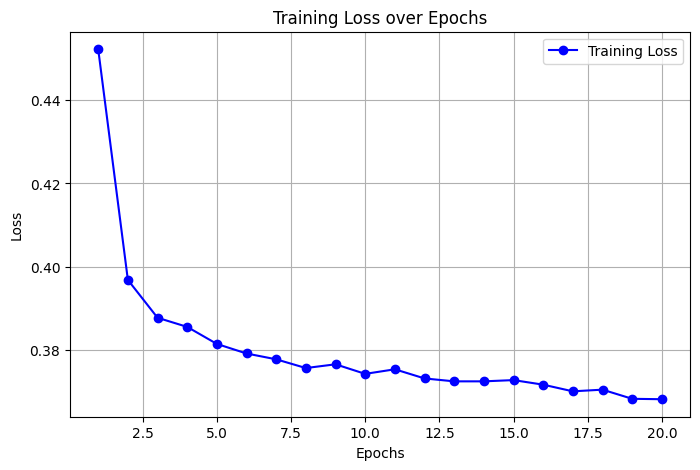

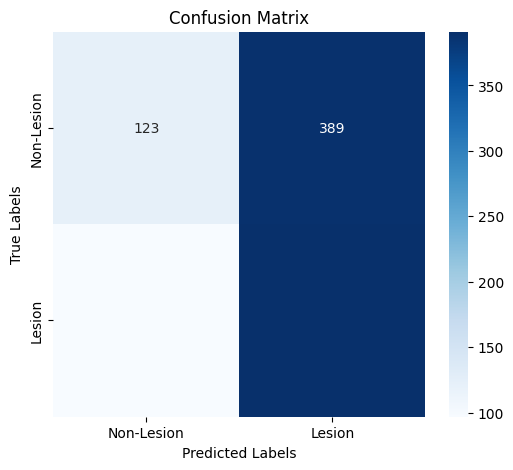

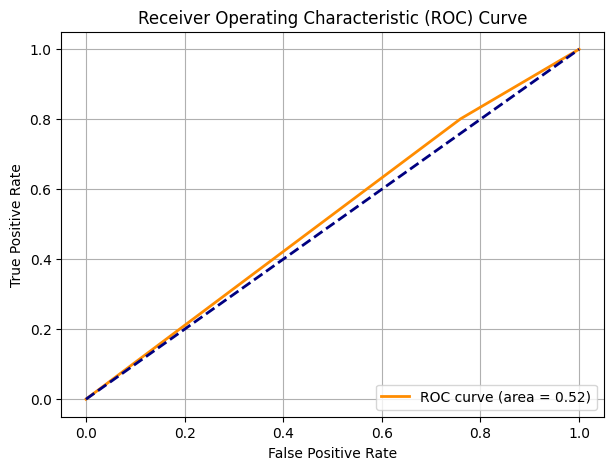

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Training loss history
epochs = np.arange(1, 21)
loss_values = [0.4523, 0.3968, 0.3877, 0.3855, 0.3814, 0.3791, 0.3777, 0.3756, 0.3765, 
               0.3742, 0.3753, 0.3731, 0.3724, 0.3724, 0.3727, 0.3716, 0.3700, 0.3704, 
               0.3682, 0.3681]

# Plot Training Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Simulated confusion matrix data
y_true = np.random.binomial(1, 0.4852, size=1000)  # Based on recall
y_pred = np.random.binomial(1, 0.7930, size=1000)  # Based on precision

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Lesion', 'Lesion'], yticklabels=['Non-Lesion', 'Lesion'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
